# Note: For testing in class model from V5 with 55 epochs and 150 batch size is going to be used.
This is a final code, but it needs to be trained on 50 epochs and batch size 150 or 200, which takes ~ 6-7 hours with sample size 400-450 images. This is the top amount given RAM available. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#### LIBRARIES

# Utils

import time
import os
import glob
import numpy as np
from numpy import array
import random
import math
import cv2

# Visualization

import matplotlib.pyplot as plt

In [0]:
# First, upload .py files with files>upload (menu to the left)
# Lib functions as modules

import feature1_images_for_training as f1
import feature2_train_test_set as f2
import model_CNN
import train_function
import psnr
import test_transform
import SR_test

In [0]:
# Keras 

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import UpSampling2D
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU, PReLU
from tensorflow.python.keras.layers import add
from tensorflow.python.keras.optimizers import Adam

In [0]:
#### STEP 0: DIRECTORIES SPECIFIED

np.random.seed(2019)
path = "/content/drive/My Drive/SR_images"
os.chdir(path)

In [5]:
!ls

HR		   model_e5_s200_bp.h5	weights_model_e50_s400.h5
LR		   model.h5		weights_model_e55_s150.h5
model_e50_s400.h5  Test_HR		weights_model_e5_s200_bp.h5
model_e55_s150.h5  Test_LR		weights_model.h5


In [6]:
#### STEP 1: FEATURES AND IMAGE TRANSFORMATIONS 

hr_paths = f1.get_paths("HR")
len(hr_paths)

1470

In [33]:
np.random.seed(2019)
hr_paths_sample = np.random.choice(hr_paths, size=400, replace=False)
len(hr_paths_sample)

400

In [0]:
start_1 = time.time()

HR_cropped =f1.cropped_imgs(hr_paths_sample)
len(HR_cropped)

end_1 = time.time()

In [0]:
#### STEP 2: TRAIN AND TEST SPLIT 

start_2 = time.time()

x_train_lr, x_train_hr, x_test_lr, x_test_hr =f2.train_test_data(HR_cropped, number_of_images = len(HR_cropped))

end_2 = time.time()

In [10]:
del HR_cropped
import gc
gc.collect()

0

In [0]:
x_train_lr = f2.ndarray_to_4dim(x_train_lr, image_size = 16)
x_train_hr = f2.ndarray_to_4dim(x_train_hr, image_size = 32)
x_test_lr = f2.ndarray_to_4dim(x_test_lr, image_size = 16)
x_test_hr = f2.ndarray_to_4dim(x_test_hr, image_size = 32)

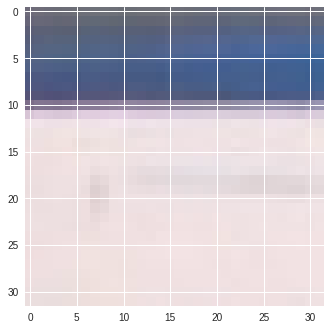

In [12]:
plt.imshow(x_train_hr[56])

In [13]:
#### STEP 3: TRAIN MODEL

start_3 = time.time()

epochs = 10
batch_size = 200

generator, generated_train, loss, val_loss = train_function.train(x_train_lr = x_train_lr, x_train_hr = x_train_hr, epochs = epochs, batch_size = batch_size)

end_3 = time.time()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 16, 16, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   36928       p_re_lu[0][0]          

In [14]:
#### STEP 4: TEST AND PLOT

test_im = generator.evaluate(x_test_lr, x_test_hr)

2451/2451 [==============================] - 3s 1ms/sample - loss: 0.0119


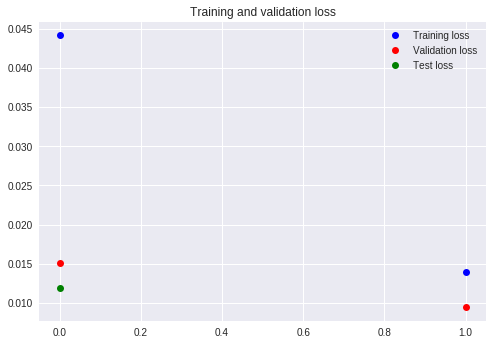

In [15]:
epoch = range(epochs)
plt.figure()
plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'ro', label='Validation loss')
plt.plot(test_im, 'go', label='Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
#Predict snippets based on model download
#Run only if you want to use pretrained model
image_shape = (16,16,3)
generator = model_CNN.Generator(image_shape).generator()
generator.load_weights('model_e55_s150.h5')

In [16]:
#Predict snippets
gen_imgs = generator.predict(x_test_lr)
len(gen_imgs)

2451

In [0]:
index = 78
result = gen_imgs[index]
test_hr = x_test_hr[index]
test_lr = x_test_lr[index]

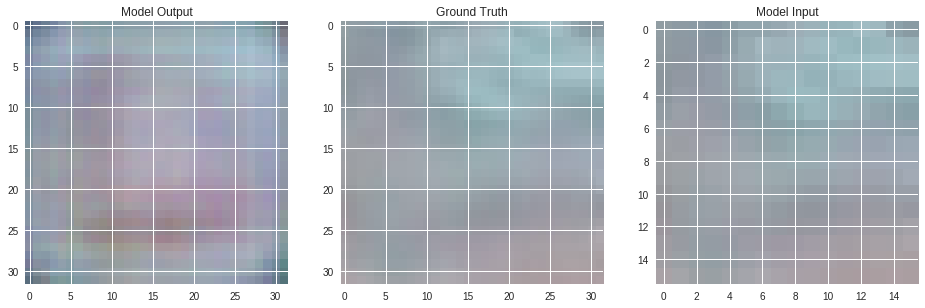

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(16, 16), sharey=False)
axs[0].imshow(result, interpolation='nearest')
axs[1].imshow(test_hr, interpolation='nearest')
axs[2].imshow(test_lr, interpolation='nearest')
axs[0].set_title("Model Output")
axs[1].set_title("Ground Truth")
axs[2].set_title("Model Input")
plt.show()

In [0]:
psnr_list = []
for i in range(len(gen_imgs)):
    psnr_item = psnr.psnr(gen_imgs[i], x_test_hr[i])
    psnr_list.append(psnr_item)

In [0]:
best = sorted(range(len(psnr_list)), key =lambda i: psnr_list[i], reverse=True)[:2]
worst = sorted(range(len(psnr_list)), key =lambda i: psnr_list[i], reverse=False)[:2]

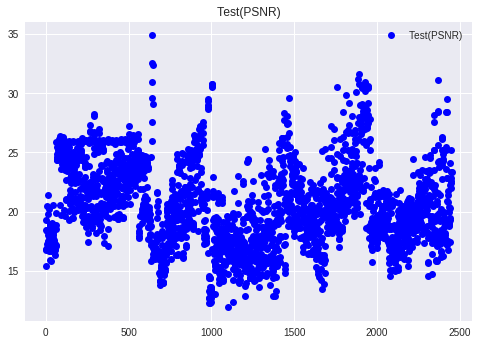

In [21]:
plt.figure()
plt.plot(psnr_list, 'bo', label='Test(PSNR)')
plt.title('Test(PSNR)')
plt.legend()
plt.show()

In [22]:
mean_psnr = np.mean(psnr_list)
mean_psnr

20.50074882740258

In [0]:
#### STEP 5: TEST - HOLDOUT DATA (whole images)

path = "/content/drive/My Drive/SR_images"
os.chdir(path)

input_pic = f1.get_paths("LR")
truth = f1.get_paths("HR")

input_pic.sort()
truth.sort()

In [0]:
input_pic = input_pic[:10]
truth = truth[:10]

In [0]:
# Testing - SR
start_4 = time.time()

whole_psnr = []
for i in range(len(input_pic)):
  psnr_score = SR_test.super_resolution(input_pic[i], truth[i], generator)[0]
  whole_psnr.append(psnr_score)
  
end_4 = time.time()

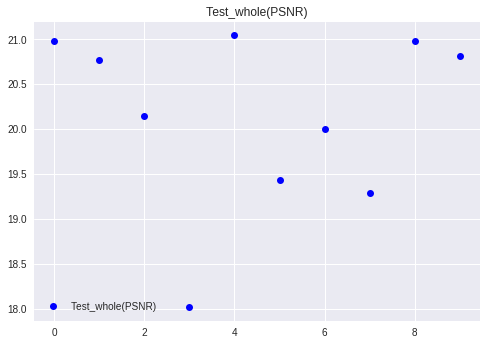

In [26]:
plt.figure()
plt.plot(whole_psnr, 'bo', label='Test_whole(PSNR)')
plt.title('Test_whole(PSNR)')
plt.legend()
plt.show()

In [0]:
lr_list = []
hr_list = []
result_list = []
for i in range(len(input_pic)):
  lr = SR_test.super_resolution(input_pic[i], truth[i], generator)[1]
  hr = SR_test.super_resolution(input_pic[i], truth[i], generator)[2]
  result = SR_test.super_resolution(input_pic[i], truth[i], generator)[3]
  lr_list.append(lr)
  hr_list.append(hr)
  result_list.append(result)

In [0]:
index = 2
result = result_list[index]
test_hr = hr_list[index]
test_lr = lr_list[index]

In [0]:
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
test_hr =  cv2.cvtColor(test_hr, cv2.COLOR_BGR2RGB)
test_lr =  cv2.cvtColor(test_lr, cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


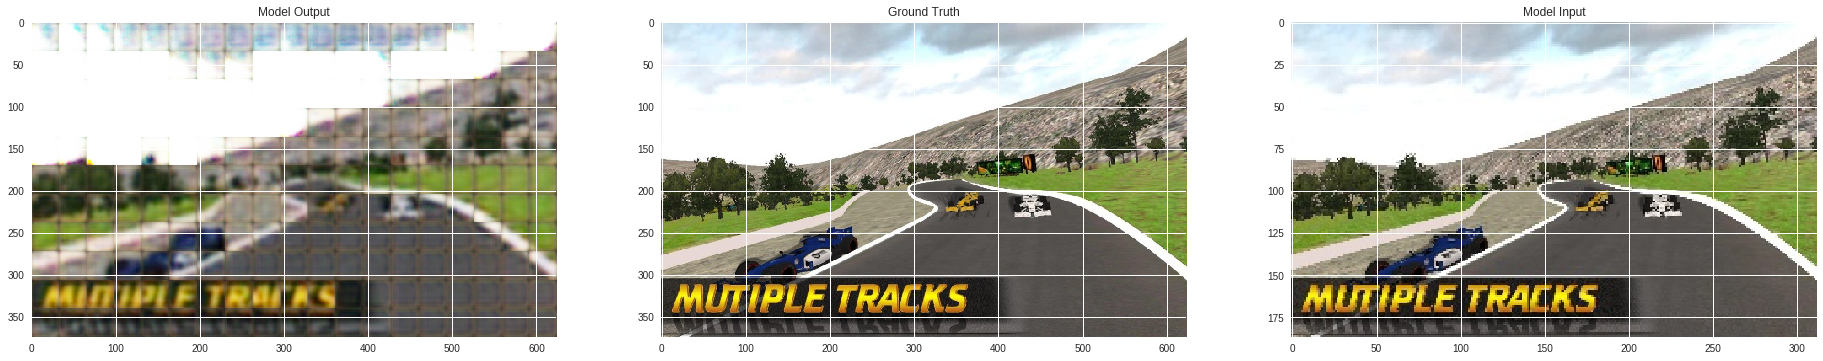

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(32, 32), sharey=False)
axs[0].imshow(result, interpolation='nearest')
axs[1].imshow(test_hr, interpolation='nearest')
axs[2].imshow(test_lr, interpolation='nearest')
axs[0].set_title("Model Output")
axs[1].set_title("Ground Truth")
axs[2].set_title("Model Input")
plt.show()

In [32]:
#### SUMMARISE RUNNING TIME
IMAGE_time = end_1 - start_1
SPLIT_time = end_2 - start_2
TRAIN_time = end_3 - start_3
TEST_time = end_4 - start_4

print("IMAGE TRANSFORMATION TIME: ", IMAGE_time)
print("TRAIN-TEST SPLIT AND DOWNSAMPLING TIME: ", SPLIT_time)
print("TRAINING TIME: ", TRAIN_time)
print("TEST_SET TIME: ", TEST_time)

IMAGE TRANSFORMATION TIME:  1.0925369262695312
TRAIN-TEST SPLIT AND DOWNSAMPLING TIME:  0.29073643684387207
TRAINING TIME:  143.12339210510254
TEST_SET TIME:  3.284491777420044
